In [143]:
import numpy as np
import commpy as cp
import matplotlib.pyplot as plt

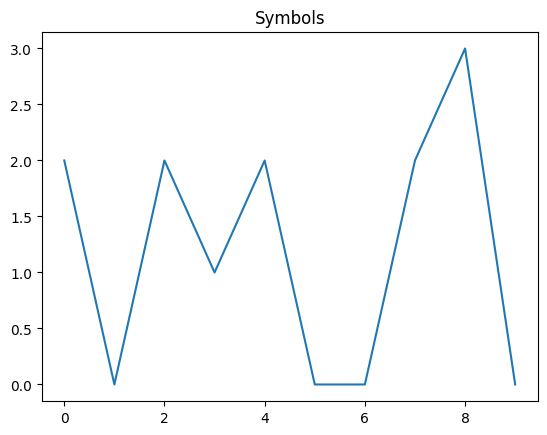

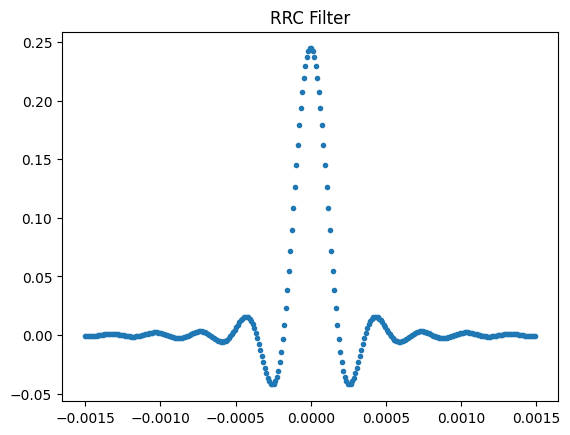

In [219]:
# define signal parameters
Fs = 1e5 # 1 kHz sampling rate
sps = 20 # 10 samples per symbol

# define data
bits_per_symbol = 2
data = np.random.randint(0, 2**bits_per_symbol, 1000)

offset_phase = 0
phases = np.linspace(0, 2*np.pi, 2**bits_per_symbol, endpoint=False)
symbols = np.exp(1j*(offset_phase + phases))
symbols_data = symbols[data]
upsampled = np.zeros(len(symbols_data)*sps, dtype=np.complex64)
upsampled[::sps] = symbols_data

fig, axs = plt.subplots(1, 1)
axs.plot(data[:10])
axs.set_title("Symbols")
plt.show()

# define rrc pulse
symbol_period = 1.0 / Fs * sps
beta = 0.35

pulse_t, pulse = cp.rrcosfilter(301, beta, symbol_period, Fs)
DeltaT = pulse_t[1] - pulse_t[0]
pulse = pulse / np.sqrt(np.sum(pulse**2))

plt.plot(pulse_t, pulse, '.')
plt.title("RRC Filter")
plt.show()

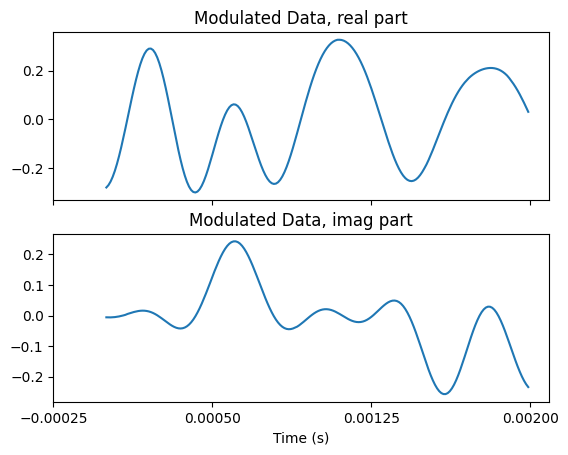

In [220]:
# modulate data
t = np.arange(0, len(upsampled)/Fs, 1/Fs)
modulated = np.convolve(upsampled, pulse, mode='same')

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(t[:int(10*sps)], modulated.real[:int(10*sps)])
axs[0].set_title("Modulated Data, real part")

axs[1].plot(t[:int(10*sps)], modulated.imag[:int(10*sps)])
axs[1].set_title("Modulated Data, imag part")
axs[1].set_xlabel("Time (s)")
new_ticks = axs[1].get_xticks()[::3]
axs[1].set_xticks(new_ticks)

plt.show()

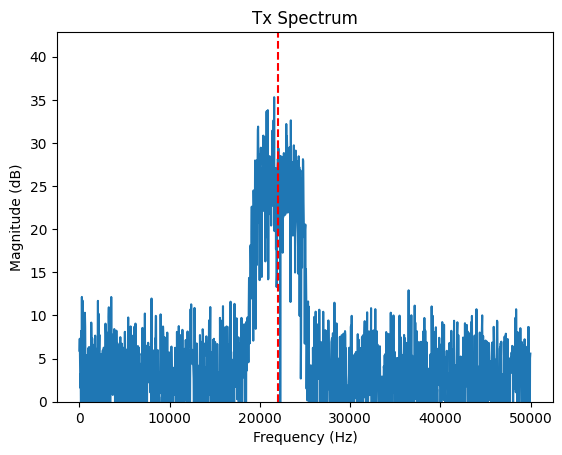

In [238]:
a = 0.8
# design tx
fc = 22000
tx = a*np.real(modulated*np.exp(1j*2*np.pi*fc*t)) + 0.1*np.random.normal(0, 0.3, len(modulated))

N = 150 # symbols to take into account for fft
X = np.fft.fftshift(np.fft.fft(tx[sps:int(N*sps)]))
freqs = np.fft.fftshift(np.fft.fftfreq(len(X), 1/Fs))


plt.plot(freqs[len(X)//2:], 20*np.log10(np.abs(X[len(X)//2:])))
plt.ylim([0, np.abs(X.max())])
ymin, ymax = plt.ylim()
plt.vlines([fc], ymin, ymax, linestyles='dashed', colors=['r'])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Tx Spectrum")
plt.show()

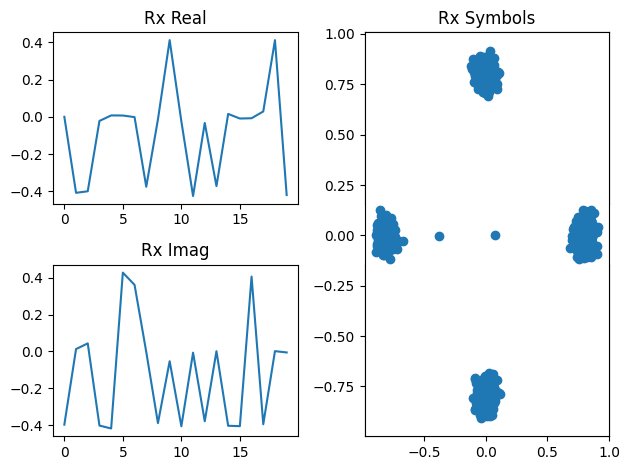

In [251]:
# get matched filter of pulse
matched_pulse = pulse.copy()
matched_pulse = matched_pulse[::-1]

matched_pulse = np.roll(matched_pulse, sps)

rx_real = tx*np.cos(2*np.pi*fc*t)
rx_imag = -1*tx*np.sin(2*np.pi*fc*t)

# apply matched filter on rx to prepare for sampling on symbol period
rx_real_LPF = np.convolve(rx_real, matched_pulse, mode='same')
rx_imag_LPF = np.convolve(rx_imag, matched_pulse, mode='same')

rx_sampled_real = rx_real_LPF[::sps]
rx_sampled_imag = rx_imag_LPF[::sps]
rx_data = 2*(rx_sampled_real + 1j*rx_sampled_imag)

fig, axs = plt.subplots(2, 2, tight_layout=True)
axs = axs.ravel()
#axs[0].plot(t[sps:100*sps], rx_real_LPF[sps:100*sps])
axs[0].plot(rx_sampled_real[sps:sps+20])
axs[0].set_title("Rx Real")

# axs[2].plot(t[sps:100*sps], rx_imag_LPF[sps:100*sps])
axs[2].plot(rx_sampled_imag[sps:sps+20])
axs[2].set_title("Rx Imag")

axs[1].set_yticks([])
axs[1].set_xticks([])
axs[3].set_yticks([])
axs[3].set_xticks([])

ax = fig.add_subplot(122)
ax.scatter(rx_data.real, rx_data.imag)
ax.set_title("Rx Symbols")

plt.show()

Text(0.5, 1.0, 'Recovered Symbols')

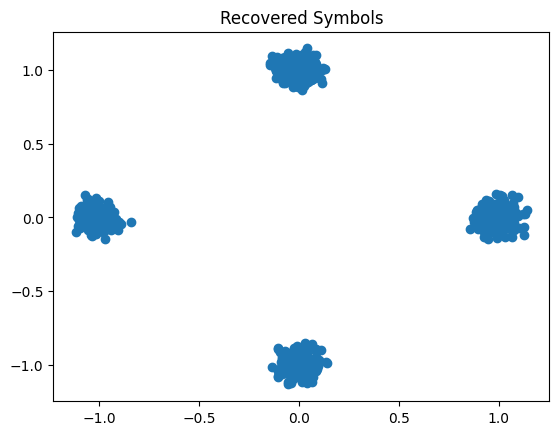

In [253]:
''' apply inverse of channel gain to recover original symbols '''

recovered_symbols = rx_data/a
plt.scatter(recovered_symbols.real[sps:], recovered_symbols.imag[sps:])
plt.title("Recovered Symbols")

In [268]:
# recover original data
demodulated = np.zeros(len(recovered_symbols), dtype=complex)
for symbol in symbols:
    demodulated[np.abs(recovered_symbols - symbol) < 0.5] = symbol


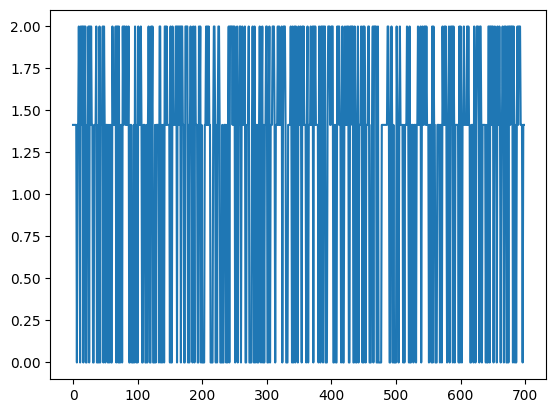

In [273]:
offset = 100
plt.plot(np.abs(demodulated[offset:] - symbols_data[:len(demodulated[offset:])]))